<a href="https://colab.research.google.com/github/sunflowerseed17/PythonDSProject/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Loading

In [6]:

# Installing modules, packages and dependencies

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

In [7]:
# Load Folders containing preprocessed posts

folders = {
    "depression": {
        "path": "preprocessed_depression_posts",
        "label": 1  # Label for depression-related posts
    },
    "breastcancer": {
        "path": "preprocessed_breastcancer_posts",
        "label": 0  # Label for breast cancer posts
    }
}

Extracting each of the separate posts from the folders (Keeping the 0 or 1 labels in order to differentiate depression and non-depression during feature extraction) 

In [8]:


documents = []
labels = []  # To store corresponding labels for each document

# Iterate through the folders
for category, data in folders.items():
    folder_path = data["path"]
    label = data["label"]
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()  # Read the file content
                documents.append(content)  # Add to documents list
                labels.append(label)  # Add corresponding label

# Check the loaded documents and labels
print(f"Loaded {len(documents)} documents.")
print(f"Labels: {set(labels)}")

Loaded 293 documents.
Labels: {0, 1}


## N-Grams

In [9]:

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(documents)

# Get the feature names (unigrams and bigrams)
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features (unigrams + bigrams): {len(feature_names)}")


Number of features (unigrams + bigrams): 34004


### Unigrams and Bigrams used to capture context (unigrams = single words, bigrams = pairs of words)

In [10]:
# Get feature names and the sum of TF-IDF scores across all documents
feature_names = vectorizer.get_feature_names_out()
tfidf_sums = np.array(tfidf_matrix.sum(axis=0)).flatten()

# Get indices of the top N most common features
top_n = 10  # Adjust to how many common features you want to see
top_indices = np.argsort(tfidf_sums)[-top_n:]  # Indices of top features

# Print the most common features
print(f"Top {top_n} Most Common Features:")
for i in reversed(top_indices):
    print(f"{feature_names[i]}: {tfidf_sums[i]:.4f}")


Top 10 Most Common Features:
feel: 11.5934
like: 10.1414
want: 7.9089
know: 7.1845
year: 6.7375
life: 6.4961
time: 6.0988
feel like: 5.7449
realli: 5.6628
thing: 5.3286


### Extract TF-IDF features, train a logistic regression model with hyperparameter tuning, and identify key features for each category.

In [11]:

# Debugging: Check documents and labels
print(f"Number of valid documents: {len(documents)}")
if documents:
    print(f"Sample document (label {labels[0]}): {documents[0]}")

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L1 is not supported by LogisticRegression with liblinear solver
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Train the best Logistic Regression model
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # No need to call .toarray() since coef_ is already a numpy array

# Get top 10 positive and negative features
top_positive_indices = np.argsort(coefficients)[-10:]  # Largest coefficients
top_negative_indices = np.argsort(coefficients)[:10]   # Smallest coefficients

print("\nTop 10 Positive Features (indicating depression):")
for i in reversed(top_positive_indices):
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\nTop 10 Negative Features (indicating breast cancer):")
for i in top_negative_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

Number of valid documents: 293
Sample document (label 1): well quit sure begin text realiti unsur anyth brazilian matter reader feel though die insid noth make sens anymor peopl claim highli intellig liar impostor syndrom might make assert seem bias noth foolish young individu gradual destroy metaphys mental navig life faith anyth incap forc use cheer altruist child often refer angel howev seri event cast abyss bottom pit discov trapdoor lead endlessli deep fall devoid prospect return tri good even know good mean truli exist unattract overweight frequent plagu allergi give perpetu sickli appear amount fit train ever succeed boost tri thing shatter refus numb cultur opiat modern though often think life within plato cave might prefer life devoid thought seem sweeter yet stop think sinc grandmoth pass 2022 everyth unravel unsur whether life lost purpos mean signific simpli thing made joy someon love care know continu live neither wish die find place social believ unpleas other claim oppos

### Visualize features from logistic regression model (bar plots and word clouds)




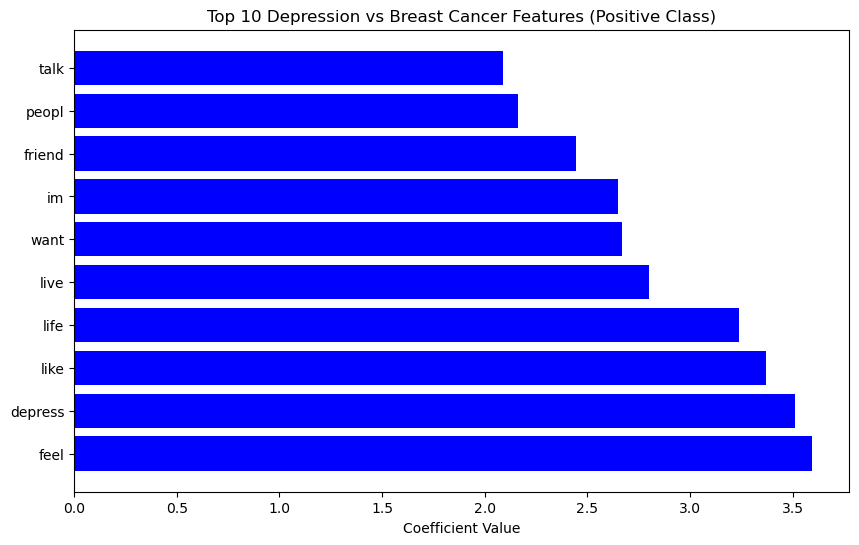

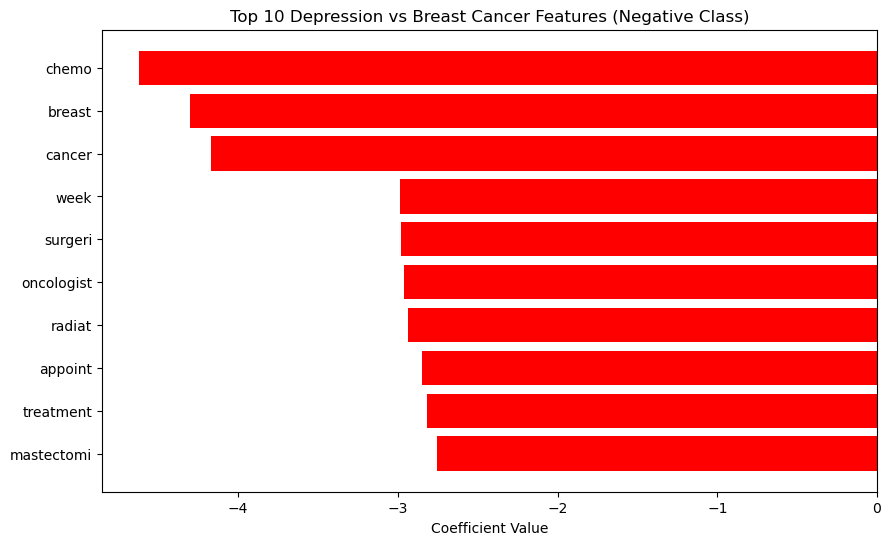

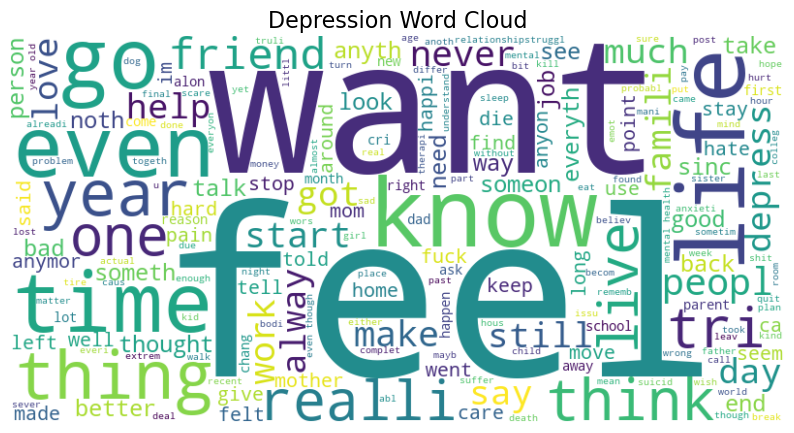

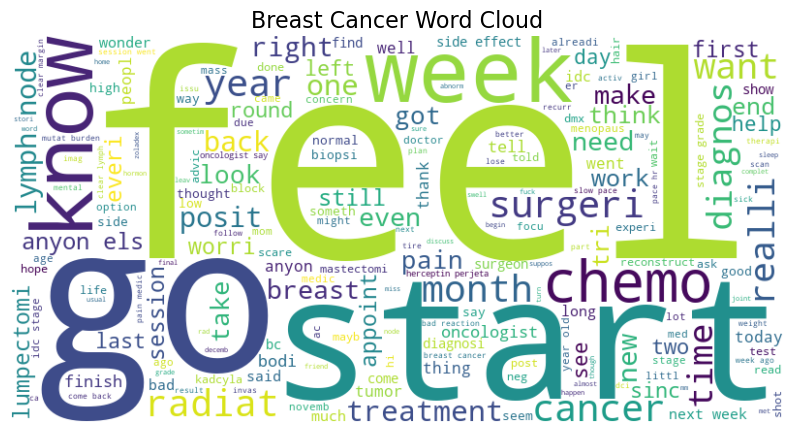

In [12]:

def visualize_features(feature_names, coefficients, title, top_n=10):
    sorted_indices = np.argsort(coefficients)
    top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[-top_n:]]
    bottom_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:top_n]]
    
    top_features.reverse()  # Largest first
    bottom_features.reverse()  # Smallest first
    
    # Plot positive features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='blue')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Positive Class)")
    plt.show()
    
    # Plot negative features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in bottom_features], [f[1] for f in bottom_features], color='red')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Negative Class)")
    plt.show()

visualize_features(feature_names, coefficients, "Depression vs Breast Cancer", top_n=10)

# Generate Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Combine all depression and breast cancer documents
depression_text = " ".join([documents[i] for i in range(len(labels)) if labels[i] == 1])
breast_cancer_text = " ".join([documents[i] for i in range(len(labels)) if labels[i] == 0])

generate_wordcloud(depression_text, "Depression Word Cloud")
generate_wordcloud(breast_cancer_text, "Breast Cancer Word Cloud")


## Empath Feature Extraction

In [13]:
# Installing modules, packages and dependencies

import pandas as pd
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
%pip install empath
from empath import Empath

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Initialising the Empath model

lexicon = Empath()

In [27]:
# Categories to focus on based on the origin paper

selected_categories = {
    "linguistic_features": [
        "articles", "auxiliary_verbs", "adverbs", "conjunctions", 
        "personal_pronouns", "impersonal_pronouns", "negations", 
        "prepositions", "verbs"
    ],
    "psychological_processes": {
        "affective": ["anxiety", "sadness", "positive_emotion", "negative_emotion", "joy", "anger"],
        "biological": ["sexual", "body", "ingestion", "health", "pain"],
        "social": ["family", "friends", "male", "female", "social_media", "communication"],
        "cognitive": ["cause", "always", "never", "because", "certainty", "doubt"],
    },
    "personal_concerns": [
        "work", "money", "death", "violence", "shopping", "travel", "home", "school"
    ],
    "time_orientations": ["present", "past", "future", "season", "day", "night"]
}

In [28]:
# Extracting features

def extract_empath_features(documents, lexicon, selected_categories):
    """
    Extracts Empath features from a list of documents based on selected categories.
    Parameters:
    documents (list of str): A list of documents to analyze.
    lexicon (Empath): An instance of the Empath lexicon for analyzing text.
    selected_categories (dict): A dictionary specifying the categories to extract. 
        It should have the following structure:
        {
            "linguistic_features": list of str,
            "psychological_processes": dict of {subcategory: list of str},
            "personal_concerns": list of str,
            "time_orientations": list of str
        }
    Returns:
    list of dict: A list of dictionaries where each dictionary contains the extracted features for a document.
    """

    features = []
    for doc in documents:
        doc_features = {}
        
        # Linguistic features
        for category in selected_categories["linguistic_features"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Psychological processes
        for subcategory, categories in selected_categories["psychological_processes"].items():
            for category in categories:
                doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Personal concerns
        for category in selected_categories["personal_concerns"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Time orientations
        for category in selected_categories["time_orientations"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        features.append(doc_features)
    return features


In [29]:
# Extracting features for each document

empath_features = extract_empath_features(documents, lexicon, selected_categories)


In [30]:
# Convert features into a DataFrame for analysis
df_features = pd.DataFrame(empath_features)

# Identify constant columns
constant_columns = df_features.columns[df_features.nunique() == 1]

# Remove constant columns
df_features = df_features.drop(columns=constant_columns)
print(f"Removed constant columns: {constant_columns.tolist()}")

if len(set(labels)) == 1:
    raise ValueError("Labels array is constant; cannot compute correlation.")

# Calculate correlation for each feature
correlations = []
p_values = []

for column in df_features.columns:
    try:
        correlation, p_value = pearsonr(df_features[column], labels)
        correlations.append(correlation)
        p_values.append(p_value)
    except ConstantInputWarning: # Handle constant features (where they have a 1 or 0 for all features, and therefore don't tell us anything)
        print(f"Skipping constant feature: {column}")
        correlations.append(None)
        p_values.append(None)

# Step 4: Apply Benjamini-Hochberg correction
_, corrected_p_values, _, _ = smm.multipletests(p_values, alpha=0.05, method="fdr_bh")

Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'anxiety', 'ingestion', 'male', 'female', 'cause', 'always', 'never', 'because', 'certainty', 'doubt', 'travel', 'present', 'past', 'future', 'season', 'day']


In [31]:
# Step 5: Display results
results = pd.DataFrame({
    "Feature": df_features.columns,
    "Correlation": correlations,
    "P-Value": p_values,
    "Corrected P-Value": corrected_p_values
})

print(results.sort_values(by="Corrected P-Value"))

             Feature  Correlation       P-Value  Corrected P-Value
16          violence     0.322123  1.687009e-08       3.542720e-07
8               pain     0.292186  3.551000e-07       3.728550e-06
2   negative_emotion     0.283624  7.980670e-07       5.586469e-06
1   positive_emotion     0.279029  1.219124e-06       6.400401e-06
15             death     0.266842  3.615479e-06       1.518501e-05
0            sadness     0.251226  1.349603e-05       4.339445e-05
10           friends     0.250375  1.446482e-05       4.339445e-05
6               body     0.218874  1.591178e-04       4.176842e-04
13              work     0.214900  2.104247e-04       4.909909e-04
3                joy     0.168279  3.867288e-03       8.121305e-03
5             sexual     0.157332  6.967262e-03       1.239367e-02
17          shopping     0.157018  7.082096e-03       1.239367e-02
18              home     0.153460  8.508626e-03       1.374470e-02
20             night     0.137263  1.874060e-02       2.811090

In [26]:
print(df_features.describe())

          sadness  positive_emotion  negative_emotion      sexual        body  \
count  293.000000        293.000000        293.000000  293.000000  293.000000   
mean     2.061433          3.566553          5.587031    0.491468    3.293515   
std      2.380640          5.209959          7.129197    1.531886    4.048828   
min      0.000000          0.000000          0.000000    0.000000    0.000000   
25%      0.000000          1.000000          1.000000    0.000000    1.000000   
50%      1.000000          2.000000          4.000000    0.000000    2.000000   
75%      3.000000          5.000000          7.000000    0.000000    4.000000   
max     16.000000         47.000000         64.000000   14.000000   48.000000   

           health      family     friends        work       money       death  \
count  293.000000  293.000000  293.000000  293.000000  293.000000  293.000000   
mean     1.907850    2.590444    2.668942    1.802048    0.860068    2.682594   
std      2.696085    8.2555

## TODO: Topic Modelling using LDA (Latent Dirichlet Allocation)

### Use the Mallet toolkit or Gensim library in Python to apply LDA

In [78]:
import mallet
import gensim

ModuleNotFoundError: No module named 'mallet'